## 1. 라이브러리 선언 / 데이터 불러오기

In [1]:
# 모델 라이브러리 선언
from sklearn import datasets, tree, linear_model

In [2]:
# 모델 정확도 라이브러리 선언
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [3]:
import pandas as pd
import numpy as np

In [4]:
featuresData = pd.read_csv("./dataset/feature_regression_example.csv")

In [5]:
featuresData.head()

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,HCLUS,PROMOTION,PRO_PERCENT
0,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201501,2015,1,1225,Y,1,Y,0.209442
1,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201502,2015,2,968,N,4,Y,0.209442
2,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201503,2015,3,1209,N,4,Y,0.208155
3,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201504,2015,4,1810,Y,2,Y,0.208155
4,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201505,2015,5,1773,N,4,Y,0.208155


## 2. 타입 통합 / 특성 숫자컬럼 추가

In [6]:
featuresData.dtypes

REGIONID         object
PRODUCTGROUP     object
PRODUCT          object
ITEM             object
YEARWEEK          int64
YEAR              int64
WEEK              int64
QTY               int64
HOLIDAY          object
HCLUS             int64
PROMOTION        object
PRO_PERCENT     float64
dtype: object

In [7]:
# location을 이용하여 featuresData의 HOLIDAY 컬럼의 Y값과 N값을 1과 0으로 변경 => 특성 값은 숫자연산 필요하기 때문에 형 변환
featuresData.loc[featuresData.HOLIDAY=='Y', 'HO_YN'] = 1
featuresData.loc[featuresData.HOLIDAY=='N', 'HO_YN'] = 0

In [8]:
featuresData.loc[featuresData.PROMOTION=='Y', 'PRO_YN'] = 1
featuresData.loc[featuresData.PROMOTION=='N', 'PRO_YN'] = 0

In [9]:
# featuresData의 YEARWEEK를 2016년 52주차까지만 추출
featuresData = featuresData[featuresData["YEARWEEK"] <= 201652]

In [10]:
featuresData.head()

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,HCLUS,PROMOTION,PRO_PERCENT,HO_YN,PRO_YN
0,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201501,2015,1,1225,Y,1,Y,0.209442,1.0,1.0
1,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201502,2015,2,968,N,4,Y,0.209442,0.0,1.0
2,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201503,2015,3,1209,N,4,Y,0.208155,0.0,1.0
3,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201504,2015,4,1810,Y,2,Y,0.208155,1.0,1.0
4,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201505,2015,5,1773,N,4,Y,0.208155,0.0,1.0


## 3. 특성선정 및 데이터 분리

In [11]:
# 상관관계 확인 : 사람이 하는게 아니라 컴퓨터가 알아서 파악해서 하도록. => corr() 함수 사용
# 연관된 정도를 나타낼뿐 인과관계를 설명하는것은 아님
#인과관계를 확인하기 위해서는 회귀분석을 통해 인과관계의 방향, 정도와 수학적 모델을 확인해 볼 수 있음
#숫자형으로 되어있는 컬럼들끼리만 비교함
corrDf = featuresData.corr()

In [12]:
corrDf.head()

,YEARWEEK,YEAR,WEEK,QTY,HCLUS,PRO_PERCENT,HO_YN,PRO_YN
YEARWEEK,1.000000,0.956598,0.275593,0.112267,-0.071586,0.404889,0.049867,0.205916
YEAR,0.956598,1.000000,-0.016493,0.028931,0.028593,0.321193,-0.031106,0.195931
WEEK,0.275593,-0.016493,1.000000,0.289766,-0.339943,0.329705,0.273710,0.060206
QTY,0.112267,0.028931,0.289766,1.000000,-0.537230,0.700195,0.505932,0.612451
HCLUS,-0.071586,0.028593,-0.339943,-0.537230,1.000000,-0.545619,-0.974601,-0.374072


In [13]:
# 인덱스컬럼 초기화
corrResult= corrDf.reset_index()

In [14]:
# 상관관계 계수 비율 선정 : 내가 선정한 계수 이상만 되면 상관관계가 있다고 함
featuresStd = 0.5

In [15]:
# Feature(특성) 선택
features = corrResult[(corrResult.QTY !=1) & (abs(corrResult.QTY) > featuresStd)]["index"].tolist() ##abs : 절댓값 구하는 함수

In [16]:
features ##여기있는 feature들이 아래 시각화에서 x0, x1, x2, x3이 되는것임

['HCLUS', 'PRO_PERCENT', 'HO_YN', 'PRO_YN']

In [17]:
label = ['QTY']

In [18]:
label

['QTY']

In [19]:
# 데이터 분리
yearweekStd = 201630

trainingData_features = featuresData[featuresData.YEARWEEK <= yearweekStd][features] #2016년 30주차까지 중 ['HCLUS', 'PRO_PERCENT', 'HO_YN', 'PRO_YN']의 값
trainingData_label = featuresData[featuresData.YEARWEEK <= yearweekStd][label]
testData_features = featuresData[featuresData.YEARWEEK > yearweekStd][features] #2016년 31주차, 32주차 중 ['HCLUS', 'PRO_PERCENT', 'HO_YN', 'PRO_YN']의 값
testData_label = featuresData[featuresData.YEARWEEK > yearweekStd] ##전체답지

## 4-1. 모델 적용 : DecisionTreeRegressor

In [21]:
# Define Model
model_method1 = tree.DecisionTreeRegressor()

# Learning (Feature & Label)
model1 = model_method1.fit(trainingData_features,trainingData_label) ## fit: 학습시킬때 쓰는 함수

In [22]:
model1

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

## 4-2. 모델 적용 : linear Regressor

In [23]:
# Define Model
model_method2 = linear_model.LinearRegression()

In [24]:
# Learning (Feature & Label)
model2 = model_method2.fit(trainingData_features,trainingData_label)

## 5-1. 예측 : DecisionTreeRegressor

In [28]:
predict = model1.predict(testData_features)

In [29]:
predict

array([1606.5       , 1606.5       ,  350.71428571, 1434.6       ,
       1434.6       , 1434.6       , 1434.6       , 1434.6       ,
       1606.5       , 1606.5       , 2620.42857143, 1606.5       ,
        350.71428571, 2193.8       , 2193.8       , 2193.8       ,
       2193.8       , 2193.8       , 2193.8       , 2193.8       ,
       2193.8       , 2193.8       ])

In [30]:
testData_label

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,HCLUS,PROMOTION,PRO_PERCENT,HO_YN,PRO_YN
83,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201631,2016,31,1522,N,4,Y,0.280258,0.0,1.0
84,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201632,2016,32,2100,N,4,Y,0.280258,0.0,1.0
85,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201633,2016,33,43,N,4,N,0.000000,0.0,0.0
86,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201634,2016,34,1700,Y,1,Y,0.308584,1.0,1.0
87,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201635,2016,35,1514,Y,1,Y,0.308584,1.0,1.0
88,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201636,2016,36,1501,Y,1,Y,0.308584,1.0,1.0
89,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201637,2016,37,1491,N,4,Y,0.308584,0.0,1.0
90,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201638,2016,38,806,N,4,Y,0.308584,0.0,1.0
91,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201639,2016,39,2111,N,4,Y,0.280258,0.0,1.0
92,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201640,2016,40,2400,N,4,Y,0.280258,0.0,1.0


## 5_2. 예측 : linear Regressor

In [31]:
predict2 = model2.predict(testData_features)

In [32]:
predict2

array([[1411.29171929],
       [1411.29171929],
       [ 300.43091536],
       [2004.96200456],
       [2004.96200456],
       [2004.96200456],
       [1586.12154967],
       [1586.12154967],
       [1411.29171929],
       [1411.29171929],
       [1799.54021119],
       [1411.29171929],
       [ 300.43091536],
       [2734.87329525],
       [2734.87329525],
       [2734.87329525],
       [2734.87329525],
       [2734.87329525],
       [2285.44087736],
       [1856.31310796],
       [1856.31310796],
       [2275.15356285]])

## 6-1. 데이터 정리 : DecisionTreeRegressor

In [33]:
#리스트형인 predict를 데이터프레임형으로 변환
predictData = pd.DataFrame(predict,columns=["PREDICT"])

testData_label = testData_label.reset_index()

#기존 데이터프레임과 예측값 구한 데이터프레임을 merge
finalResult = pd.concat([testData_label, predictData], axis = 1) 

In [34]:
finalResult

,index,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,HCLUS,PROMOTION,PRO_PERCENT,HO_YN,PRO_YN,PREDICT
0,83,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201631,2016,31,1522,N,4,Y,0.280258,0.0,1.0,1606.500000
1,84,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201632,2016,32,2100,N,4,Y,0.280258,0.0,1.0,1606.500000
2,85,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201633,2016,33,43,N,4,N,0.000000,0.0,0.0,350.714286
3,86,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201634,2016,34,1700,Y,1,Y,0.308584,1.0,1.0,1434.600000
4,87,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201635,2016,35,1514,Y,1,Y,0.308584,1.0,1.0,1434.600000
5,88,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201636,2016,36,1501,Y,1,Y,0.308584,1.0,1.0,1434.600000
6,89,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201637,2016,37,1491,N,4,Y,0.308584,0.0,1.0,1434.600000
7,90,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201638,2016,38,806,N,4,Y,0.308584,0.0,1.0,1434.600000
8,91,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201639,2016,39,2111,N,4,Y,0.280258,0.0,1.0,1606.500000
9,92,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201640,2016,40,2400,N,4,Y,0.280258,0.0,1.0,1606.500000


## 6-2. 데이터 정리 : linear Regressor

In [35]:
prdedictData2 = pd.DataFrame(predict2, columns=["RENEAR_REGRESSOR"])

In [36]:
finalResult2 = pd.concat([testData_label, prdedictData2], axis = 1)

In [37]:
finalResult2

,index,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,HCLUS,PROMOTION,PRO_PERCENT,HO_YN,PRO_YN,RENEAR_REGRESSOR
0,83,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201631,2016,31,1522,N,4,Y,0.280258,0.0,1.0,1411.291719
1,84,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201632,2016,32,2100,N,4,Y,0.280258,0.0,1.0,1411.291719
2,85,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201633,2016,33,43,N,4,N,0.000000,0.0,0.0,300.430915
3,86,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201634,2016,34,1700,Y,1,Y,0.308584,1.0,1.0,2004.962005
4,87,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201635,2016,35,1514,Y,1,Y,0.308584,1.0,1.0,2004.962005
5,88,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201636,2016,36,1501,Y,1,Y,0.308584,1.0,1.0,2004.962005
6,89,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201637,2016,37,1491,N,4,Y,0.308584,0.0,1.0,1586.121550
7,90,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201638,2016,38,806,N,4,Y,0.308584,0.0,1.0,1586.121550
8,91,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201639,2016,39,2111,N,4,Y,0.280258,0.0,1.0,1411.291719
9,92,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201640,2016,40,2400,N,4,Y,0.280258,0.0,1.0,1411.291719


## 7. 결과 검증 

In [38]:
# MAE : 단순하게 답과 예측값의 차이만 구한 후 평균을 구함
mean_absolute_error(finalResult['QTY'], finalResult['PREDICT'])

460.25259740259736

In [39]:
import math

In [40]:
# RMSE(MSE) : 모든 오차를 제곱으로(증폭시킴) 한 후 루트를 씌워서 안정화시켜줌
math.sqrt(mean_squared_error(finalResult['QTY'], finalResult['PREDICT']))

603.7396042425769

In [41]:
# R2
r2_score(finalResult['QTY'], finalResult['PREDICT'])

0.21932322337186283

## 8-1. 시각화

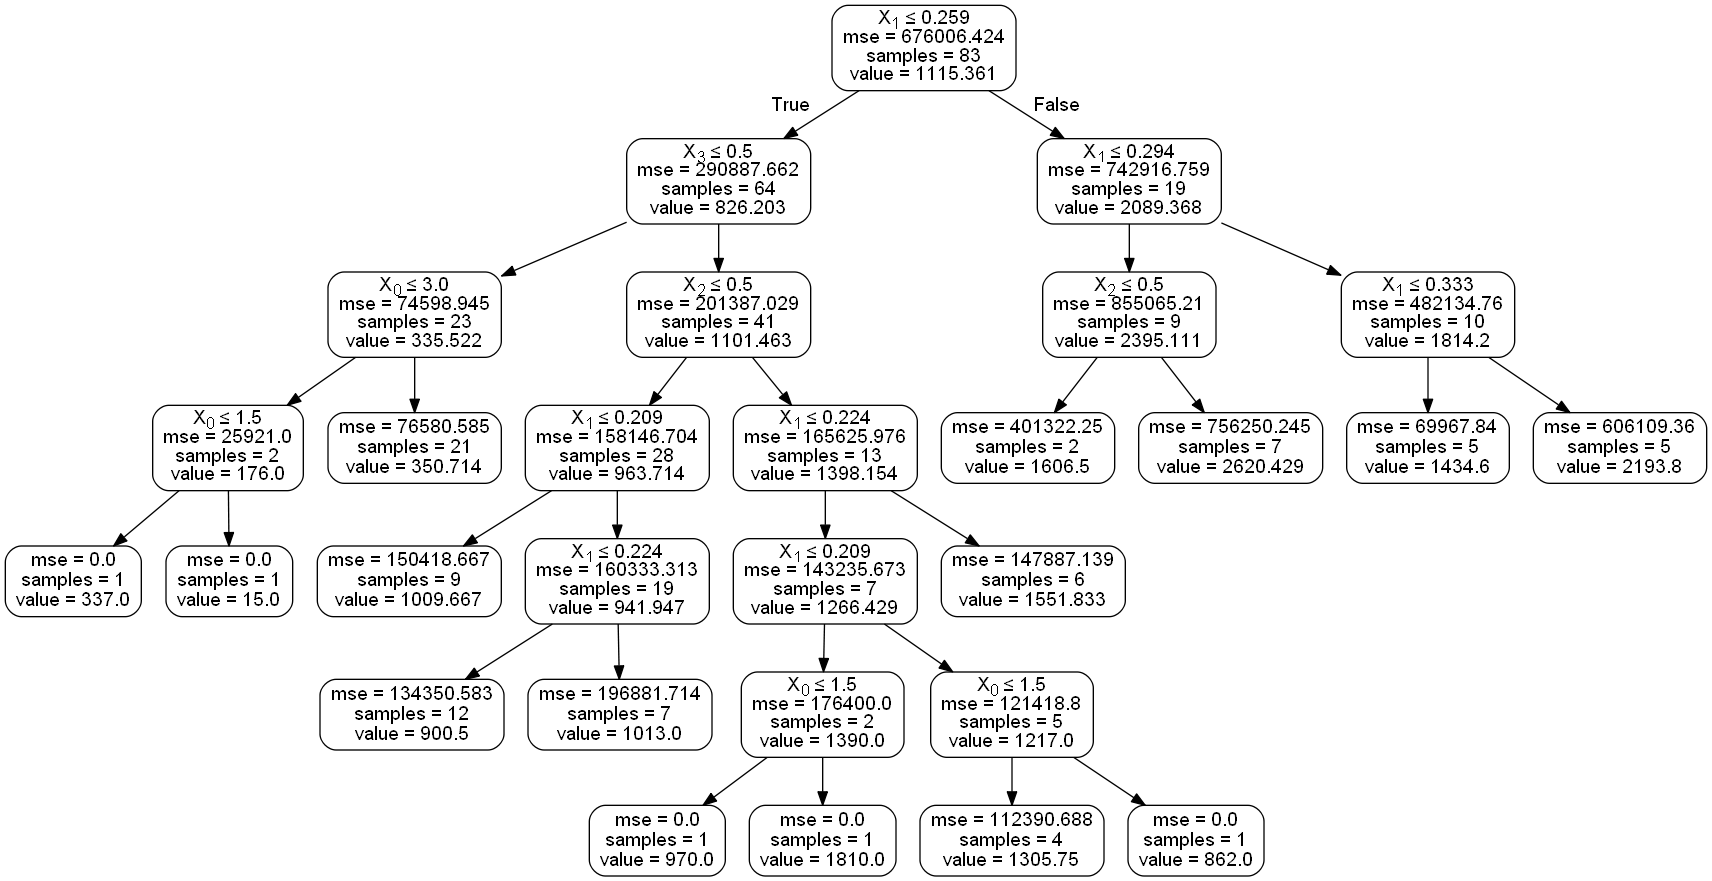

In [43]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(model1, out_file=dot_data, 
                rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

## 8-2. 데이터 시각화

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline

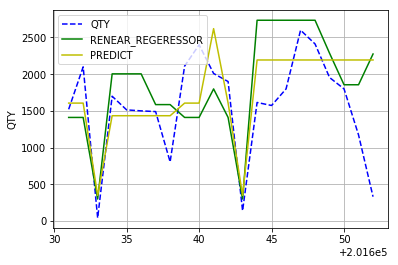

In [60]:
x = finalResult["YEARWEEK"]
y = finalResult["QTY"]
y2 = finalResult2["RENEAR_REGRESSOR"]
y3 = finalResult["PREDICT"]

plt.plot(x, y, 'b--', lw=1.5, label = 'QTY')
plt.grid(True)
plt.ylabel('QTY') # y축 이름

plt.plot(x, y2, 'g', lw=1.5, label = 'RENEAR_REGERESSOR')
plt.legend(loc=0) #라벨 위치

plt.plot(x, y3, 'y', lw=1.5, label = 'PREDICT')
plt.legend(loc=0)